In [1]:
import os
import shutil

img_rows = 137
img_cols = 236
color_type = 1
batch_size=80
epochs=300
subject='Bengali'
main_path=os.path.join("E:\\kaggle_imgs",subject)
img_path=os.path.join(main_path,"imgs")
data_path=os.path.join(main_path,"Data")
saved_path=os.path.join(main_path,"saved_models")
paths=[main_path, img_path,saved_path,data_path]
for fp in paths:
    print(fp)
    if not os.path.exists(fp):        
        os.mkdir(fp)
file_path=os.path.join(saved_path,subject+"200511.hdf5")

train_img_pkl=os.path.join(data_path,"train_data_ch3.npy")
test_img_pkl=os.path.join(data_path,"test_data")
train_info_pkl=os.path.join(data_path,"df_train_pickle.csv")


E:\kaggle_imgs\Bengali
E:\kaggle_imgs\Bengali\imgs
E:\kaggle_imgs\Bengali\saved_models
E:\kaggle_imgs\Bengali\Data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [20]:
def read_train_info():
    fp=train_info_pkl
    if os.path.exists(fp):
        try:
            print('loading train data from csv', flush=True)
            df_train=pd.read_csv(fp)
            print('complete!', flush=True)
        except EOFError:
            print('EOFError raised.', flush=True)
        
    else:
        df_train=pd.read_csv(data_path+"/train.csv")
        df_train["id"]=df_train["image_id"].apply(lambda x : int(x.split("_")[1]))        
        X=df_train[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values[:,0]
        y=df_train[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values[:,1:]
        mskf=MultilabelStratifiedKFold(n_splits=6,random_state=22)        
        df_train["fold"]=-1
        for i, (trn_idx,vld_idx) in enumerate(mskf.split(X,y)):
            df_train.loc[vld_idx,"fold"]=i
        print('save train data to csv', flush=True)
        df_train.to_csv(df_train_pickle,index=False)
    return df_train
df_train=read_train_info()

loading train data from csv
complete!


In [5]:
# f,ax=plt.subplots(figsize=(10,30))
# sns.countplot(y=df_train.grapheme_root)

In [6]:
# f,ax=plt.subplots(figsize=(10,10))
# sns.countplot(y=df_train.vowel_diacritic)

In [7]:
all_img=[]
all_lbl=[]
def read_img():
    fp=train_img_pkl
    if os.path.exists(fp+"0.npz"):
        try:
            for i in range(4):
                f=np.load(fp+"{}.npz".format(i),allow_pickle=True)
                img_idx=f["lab"]
                img_arr=f["img"]
                all_img.append(np.array(img_arr))
                all_lbl.append(np.array(img_idx).reshape(-1,1))
                print(i,"load complete")
        except EOFError:
            print('EOFError raised.', flush=True)
    else:
        for i in range(4):
            img_parquet=img_path+"/train_image_data_{}.parquet".format(i)
            file=pd.read_parquet(img_parquet)
            print("{i} parquet read complete")
            img_idx=file.image_id.values
            img_arr=file.iloc[:,1:].values
            img_arr=img_arr.astype(np.uint8)
            print("{i} pandas to numpy complete")
            img_path_train=os.path.join(img_path,"train")
            np.savez(train_pickle+"{}".format(i),img=img_arr,lab=img_idx)
            print("{i} numpy save complete")
            all_img.append(img_arr)
            all_lbl.append(img_idx)
            
    train_all_img=np.vstack(all_img)
    train_all_lbl=np.vstack(all_lbl)
    return train_all_img,train_all_lbl

train_all_img,train_all_lbl = read_img()

0 load complete
1 load complete
2 load complete
3 load complete


In [68]:
class Bengali():
    def __init__(self,csv,rows,cols):
        self.csv=csv.reset_index()
        self.img_ids=csv["id"].values
        self.img_rows=rows
        self.img_cols=cols
        
    def __len__(self):
        return len(self.csv)
    
    def getitem(self,index):
        img=pd.DataFrame(train_all_img)
        img=img.iloc[index]
        img=img.values
        img=255-img
        img=img.reshape(-1,img_rows,img_cols,color_type)
        
        lbl1=self.csv.iloc[index].grapheme_root
        lbl2=self.csv.iloc[index].vowel_diacritic
        lbl3=self.csv.iloc[index].consonant_diacritic
        
        return (img,lbl1,lbl2,lbl3)
    
a=Bengali(df_train,img_rows,img_cols)        

In [79]:
ids=df_train[df_train["fold"]==0].index

In [82]:
img,lbl1,lbl2,lbl3=a.getitem(ids)

In [23]:
train_all_img.iloc[[1,3]]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [24]:
df=pd.DataFrame(train_all_img)

In [26]:
df_train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,5
1,Train_1,159,0,0,হ,1,5
2,Train_2,22,3,5,খ্রী,2,4
3,Train_3,53,2,2,র্টি,3,0
4,Train_4,71,9,5,থ্রো,4,1


In [8]:
train_all_img.shape,train_all_lbl.shape

((200840, 32332), (200840, 1))

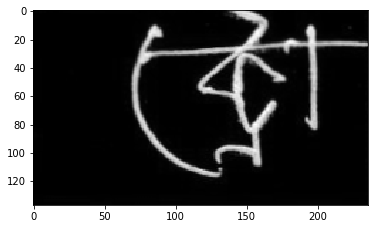

In [18]:
plt.imshow(255-train_all_img[0].reshape(img_rows,img_cols),cmap="gray")

In [21]:
df_train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,5
1,Train_1,159,0,0,হ,1,5
2,Train_2,22,3,5,খ্রী,2,4
3,Train_3,53,2,2,র্টি,3,0
4,Train_4,71,9,5,থ্রো,4,1


In [193]:
train0.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [208]:
train0[0]

KeyError: 0

In [201]:
a=np.array([1.5,3.5])

In [202]:
a

array([1.5, 3.5])

In [205]:
a=a.astype(np.uint8)

In [206]:
a

array([1, 3], dtype=uint8)